In [400]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import VariationalInference, RegularisedLowerIncompleteGamma, GradLambdaRegularisedLowerIncompleteGamma

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [156]:
class GaussianFamilyOn2DGaussianPosterior(VariationalInference):
    
    def __init__(self, mu_0, sigma_0, lr=0.001, base_samples=100):
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.true_parameters = [mu_0, sigma_0]
        
        self.mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
        self.logsigma = nn.Parameter(torch.tensor([np.log(0.9)], dtype=torch.float))
        self.parameters = [self.mu, self.logsigma]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        self.base_samples = base_samples
        super(GaussianFamilyOn2DGaussianPosterior, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        q = tdist.MultivariateNormal(loc=self.mu, covariance_matrix=torch.eye(2) * torch.exp(2 * self.logsigma))
        xi = q.rsample((self.base_samples, ))
        term1 = q.log_prob(xi)
        term2 = torch.sum((xi - self.mu_0)**2, dim=1) / (2 * self.sigma_0**2)
        return -torch.mean(term1 + term2)
    
    def report_optim_step(self):
        print(
            f"Epoch {self.epoch:5d}: mu={np.around(self.mu.detach().tolist(), 2)}, "
            f"sigma={torch.exp(self.logsigma).item():.3f}, elbo={self.elbo:.2f}"
        )

    def true_unnormalised_density(self, w):
        q = tdist.MultivariateNormal(loc=self.mu_0, covariance_matrix=torch.eye(2) * self.sigma_0)
        z = np.exp(q.log_prob(w))
        return z
    
    def variational_density(self, w, parameters):
        mu, logsigma = parameters
        q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
        z = np.exp(q.log_prob(w))
        return z

Epoch     1: mu=[0.1 0.9], sigma=0.899, elbo=-1.41
Epoch   101: mu=[0.19 0.8 ], sigma=0.819, elbo=-1.01
Epoch   201: mu=[0.27 0.72], sigma=0.757, elbo=-0.45
Epoch   301: mu=[0.34 0.64], sigma=0.706, elbo=-0.32
Epoch   401: mu=[0.39 0.57], sigma=0.664, elbo=-0.06
Epoch   501: mu=[0.43 0.51], sigma=0.630, elbo=0.13
Epoch   601: mu=[0.46 0.46], sigma=0.603, elbo=0.32
Epoch   701: mu=[0.47 0.42], sigma=0.580, elbo=0.35
Epoch   801: mu=[0.49 0.39], sigma=0.562, elbo=0.39
Epoch   901: mu=[0.5  0.36], sigma=0.548, elbo=0.36


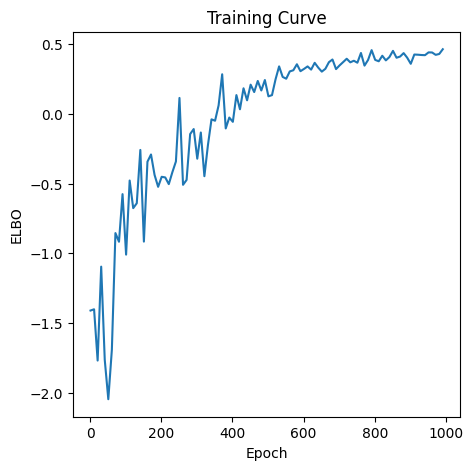

In [157]:
gaussian_vi = GaussianFamilyOn2DGaussianPosterior(
    mu_0=torch.tensor([0.5, 0.3]), 
    sigma_0=torch.tensor([0.5])
)
gaussian_vi.run_parameter_optimisation(1000)
fig = gaussian_vi.plot_training_curve();

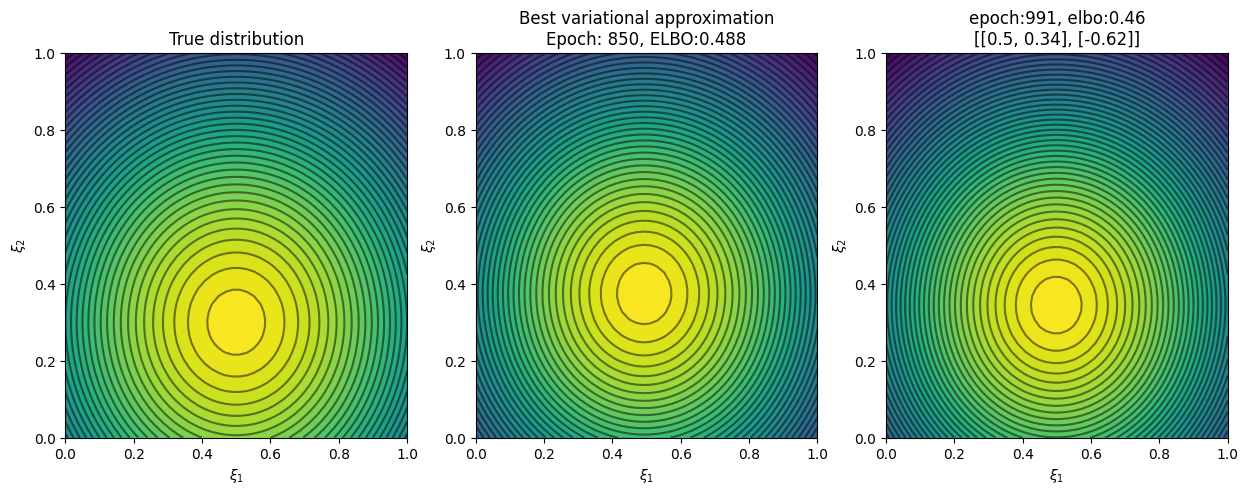

In [158]:
fig, video = gaussian_vi.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [186]:
@interact(
    n=(2, 10000), 
    t=(-2.0, 2.0)
)
def _plot_contour(n=50, t=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.linspace(-1, 1, num=1000)
    ax.plot(x, np.cos(2 * np.pi * n * (x**4 + t * x)) * (1 - np.exp(-1/x**2)), alpha=0.8)
    ax.plot(x, (1 - np.exp(-1/x**2)), color="r", alpha=0.5)
    ax.plot(x, -(1 - np.exp(-1/x**2)), color="r", alpha=0.5)

interactive(children=(IntSlider(value=50, description='n', max=10000, min=2), FloatSlider(value=0.5, descripti…

In [204]:
N = 200
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))
w = np.stack((xx, yy), axis=-1)



@interact(
    n=(2, 100000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=500, k1=2, k2=3, h1=1, h2=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    h = np.array([h1, h2])
    k = np.array([k1, k2])
    boltzman_weight = lambda w: np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    integrand = lambda y, x: boltzman_weight(np.array([x, y]))
    z = boltzman_weight(w)
    evidence = scipy.integrate.dblquad(integrand, 0, 1, 0, 1)

#     z = np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    normalising_const = np.sum(z) / (N**2)
    lambdas = (h + 1) / (2 * k)
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
#         - np.log(scipy.special.factorial(m -1)) 
        - m * np.log(2)
    )
    
    if m == 2: 
        const_term -= np.sum(np.log(k))
    elif m == 1:
        i = np.argmin(lambdas)
        j = np.argmax(lambdas)
        const_term -= np.log(k[i])
        const_term -= np.log(lambdas[j] - lambdas[i])
    
    leading_terms = rlct * np.log(n) - (m -1) * np.log(np.log(n))
    print(
        f"evidence         = {evidence}\n"
        f"-logZ integrated = {-np.log(evidence[0])}\n"
        f"-logZ            = {-np.log(normalising_const)}\n"
        f"RLCT             = {rlct}\n"
        f"m                = {m}\n"
        f"const            = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n         = {leading_terms}\n"
        f"rlct log(n) - (m - 1) log log n - log C = {leading_terms - const_term}\n"
        f"Residue          = {-np.log(evidence[0]) - leading_terms + const_term}\n"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=100000, min=2), IntSlider(value=2, description…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

In [160]:
class GaussianFamilyOn2DStandardForm(VariationalInference):
    
    def __init__(self, n, k_0, h_0, lr=0.001, base_samples=100):
        self.n = n
        self.k_0 = k_0
        self.h_0 = h_0
        self.true_parameters = [k_0, h_0]
        self.mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
        self.logsigma = nn.Parameter(torch.tensor([np.log(0.3)], dtype=torch.float))
#         self.mu = nn.Parameter(torch.rand(2, dtype=torch.float))
#         self.logsigma = nn.Parameter(torch.log(1 + torch.rand(1, dtype=torch.float)))
        self.parameters = [self.mu, self.logsigma]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        self.base_samples = base_samples
        super(GaussianFamilyOn2DStandardForm, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        q = tdist.MultivariateNormal(loc=self.mu, covariance_matrix=torch.eye(2) * torch.exp(2 * self.logsigma))
        xi = q.rsample((self.base_samples, ))
        term1 = q.log_prob(xi)
        term2 = torch.sum(torch.log(torch.abs(xi)) * self.h_0, dim=1)
        term3 = self.n * torch.prod(xi**(2 * self.k_0), dim=1)
        elbo = -torch.mean(term1 - term2 + term3)
        return elbo
    
    def report_optim_step(self):
        print(
            f"Epoch {self.epoch:6d}: mu={np.around(self.mu.detach().tolist(), 2)}, "
            f"sigma={torch.exp(self.logsigma).item():.3f}, elbo={self.elbo:.2f}"
        )

    def true_unnormalised_density(self, w):
        z = torch.abs(torch.prod(w**self.h_0, dim=-1)) * torch.exp(-n * torch.prod(w ** (2 * self.k_0), dim=-1))
        return z
    
    def variational_density(self, w, parameters):
        mu, logsigma = parameters
        q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
        z = np.exp(q.log_prob(w))
        return z

gaussian_on_standard_form = GaussianFamilyOn2DStandardForm(
    n=500,
    k_0=torch.tensor([2, 3]), 
    h_0=torch.tensor([1, 2]), 
    lr=0.001
)

Epoch      1: mu=[0.1 0.9], sigma=0.300, elbo=-24.37
Epoch   1501: mu=[0.07 0.59], sigma=0.217, elbo=-3.60
Epoch   3001: mu=[0.07 0.61], sigma=0.203, elbo=-4.33
Epoch   4501: mu=[0.02 0.62], sigma=0.207, elbo=-3.81
Epoch   6001: mu=[0.05 0.64], sigma=0.198, elbo=-4.21
Epoch   7501: mu=[0.02 0.64], sigma=0.200, elbo=-4.07
Epoch   9001: mu=[0.01 0.64], sigma=0.200, elbo=-4.31
Epoch  10501: mu=[0.01 0.66], sigma=0.200, elbo=-4.01
Epoch  12001: mu=[0.   0.65], sigma=0.200, elbo=-4.04
Epoch  13501: mu=[0.02 0.63], sigma=0.198, elbo=-4.08


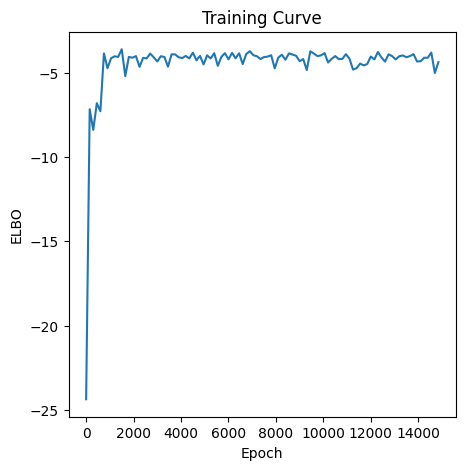

In [161]:
gaussian_on_standard_form.run_parameter_optimisation(15000)
fig = gaussian_on_standard_form.plot_training_curve();

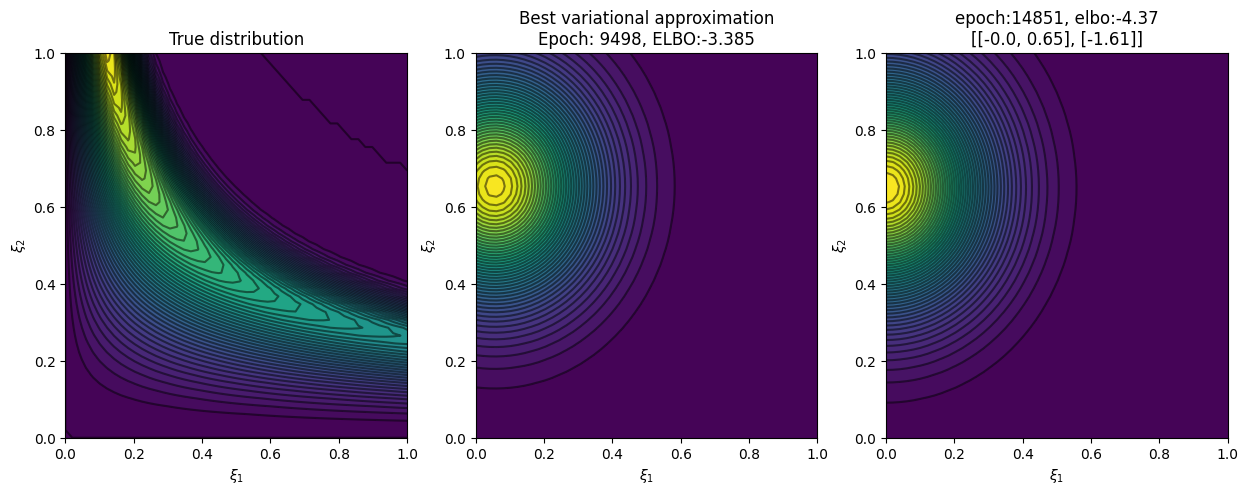

In [162]:
fig, video = gaussian_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j +2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$


Note: 
 * It seems like making $\beta$ really large in the above expression maximises the ELBO expression .. This might be a consequence of the fact that the vairational distribution is not absolutely continuous w.r.t. the posterior ...? 
 * But with $n$ large or $\beta$ large, the constribution outside of the unit cube shouldn't matter much ...? 

In [329]:
class MeanFieldGammaOn2DStandardForm(VariationalInference):
    
    def __init__(self, n, k_0, lambda_0, lr=0.001):
        self.n = n
        self.k_0 = k_0
        self.lambda_0 = lambda_0
        self.h_0 = 2 * k_0 * lambda_0 - 1
        self.true_parameters = [lambda_0, k_0, n]
        
        self.loglambdas = nn.Parameter(torch.log(lambda_0))
        self.logks = nn.Parameter(torch.log(k_0))
        self.logbetas = nn.Parameter(torch.log(torch.tensor([n, 1.])))
        self.parameters = [self.loglambdas, self.logks, self.logbetas]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        super(MeanFieldGammaOn2DStandardForm, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        lambdas, ks, betas = [torch.exp(param) for param in self.parameters]
        r = self.k_0 / ks
        
        term1 = self.n * torch.exp(torch.sum(
            -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        ))
        
        term2 = torch.sum(
            torch.log(2 * ks) + lambdas * torch.log(betas) 
            - torch.lgamma(lambdas) - lambdas 
            + (lambdas - r * self.lambda_0) * (torch.digamma(lambdas) - torch.log(betas))
        )
        return -term1 - term2
    
    def report_optim_step(self):
        lambdas, ks, betas = [torch.exp(param).detach() for param in self.parameters]

        print(
            f"Epoch {self.epoch:5d}: elbo={self.elbo:.2f}\n"
            f"lambdas={list(np.around(lambdas.tolist(), 2))}\n"
            f"ks     ={list(np.around(ks.tolist(), 2))}\n"
            f"betas  ={list(np.around(betas.tolist(),2))}\n"
        )

    def true_unnormalised_density(self, w):
        z = torch.abs(torch.prod(w**self.h_0, dim=-1)) * torch.exp(-n * torch.prod(w ** (2 * self.k_0), dim=-1))
        return z
    
    def variational_density(self, w, parameters):
        lambdas, ks, betas = [torch.exp(param).detach().numpy() for param in parameters]
        w = w.numpy()
        z = w ** (2 * ks * lambdas - 1) * np.exp(-betas * (w**ks))
        normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
        z = np.prod(z / normalising_const, axis=-1)
        return z

    

n        = 1000
lambda_0 = tensor([0.3000, 0.7500])
ks_0     = tensor([3, 4])

Epoch     0: elbo=-4.26
lambdas=[0.34, 0.8]
ks     =[3.0, 4.0]
betas  =[999.0, 1.0]

Epoch  1000: elbo=1.47
lambdas=[1.23, 3.21]
ks     =[0.98, 0.77]
betas  =[3836.6, 0.27]

Epoch  2000: elbo=101.34
lambdas=[12.75, 22.13]
ks     =[0.07, 0.09]
betas  =[47988.38, 0.04]

Epoch  3000: elbo=1172.74
lambdas=[112.86, 172.39]
ks     =[0.01, 0.01]
betas  =[499671.91, 0.01]

Epoch  4000: elbo=2093.12
lambdas=[218.91, 408.54]
ks     =[0.0, 0.01]
betas  =[1099330.12, 0.0]

Epoch  5000: elbo=2100.45
lambdas=[219.15, 409.21]
ks     =[0.0, 0.01]
betas  =[1098811.25, 0.0]

Epoch  6000: elbo=2112.84
lambdas=[219.56, 410.3]
ks     =[0.0, 0.01]
betas  =[1097763.88, 0.0]

Epoch  7000: elbo=2133.22
lambdas=[220.24, 412.1]
ks     =[0.0, 0.01]
betas  =[1096399.5, 0.0]

Epoch  8000: elbo=2166.96
lambdas=[221.36, 415.11]
ks     =[0.0, 0.01]
betas  =[1094019.25, 0.0]

Epoch  9000: elbo=2223.01
lambdas=[223.22, 420.15]
ks     =[0.0, 0

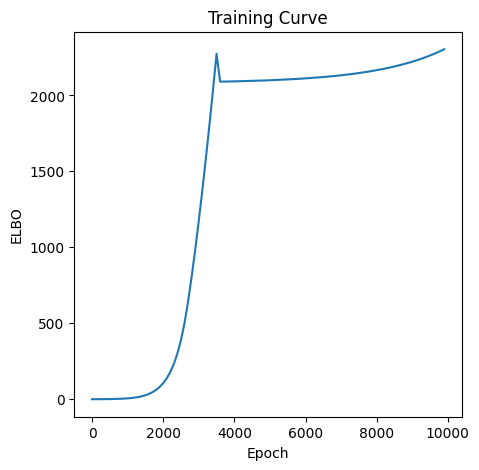

In [258]:
n = 1000
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/4])
h_0 = 2 * k_0 * lambda_0 - 1

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
)

mean_field_gamma_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0 = torch.tensor([12/35, 16/20])
)

mean_field_gamma_on_standard_form.run_parameter_optimisation(10000)
mean_field_gamma_on_standard_form.plot_training_curve();

/tmp/ipykernel_224354/3501542417.py:51: RuntimeWarning: overflow encountered in power
  normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
/tmp/ipykernel_224354/3501542417.py:51: RuntimeWarning: invalid value encountered in divide
  normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/edmund/variational-approximation-for-singular-models/notebooks/utils.py:92: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, lev

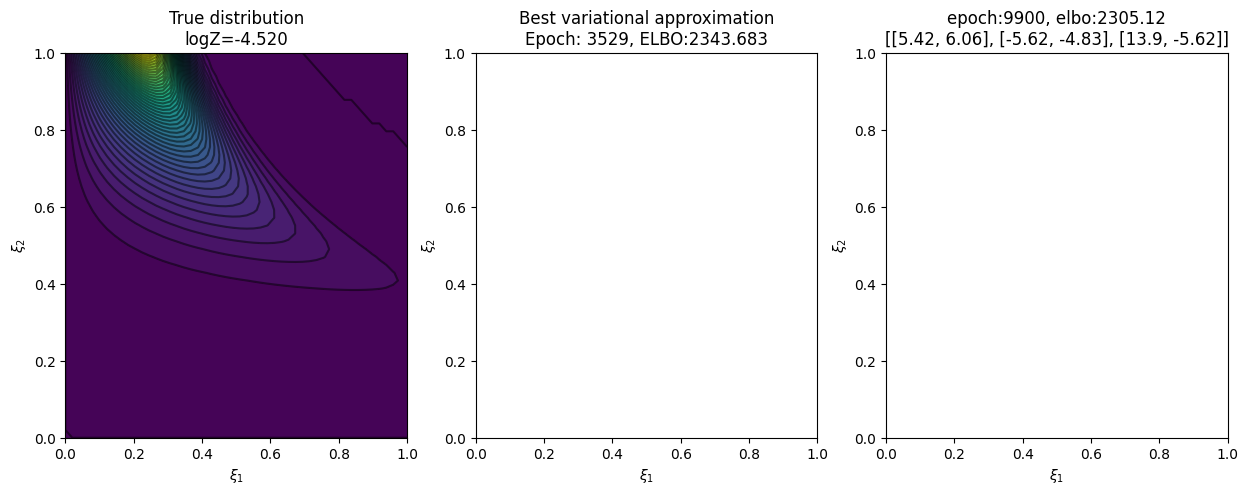

In [259]:
fig, video = mean_field_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


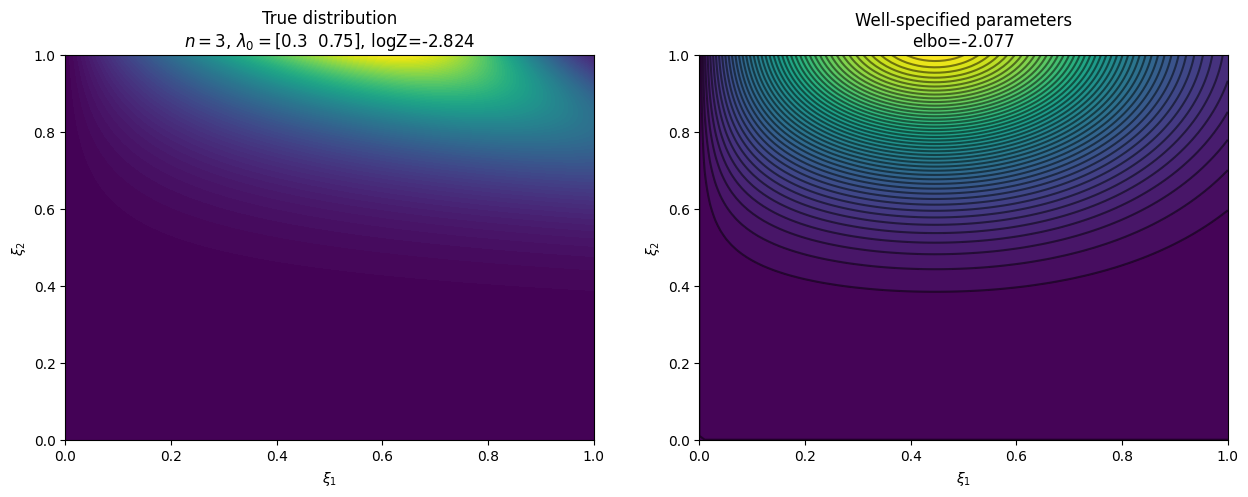

In [364]:
def elbo_func(lambdas, ks, betas, lambdas_0, ks_0, n):
    r = ks_0 / ks
    term1 = n * torch.exp(torch.sum(
        -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
    ))
    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * torch.log(betas) 
        - torch.lgamma(lambdas) - lambdas 
        + (lambdas - r * lambdas_0) * (torch.digamma(lambdas) - torch.log(betas))
    )
    return -term1 - term2

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
N = 100
levels = 50
a, b = 0, 1
xx, yy = torch.meshgrid(torch.linspace(a, b, N), torch.linspace(a, b, N))
w = torch.stack((xx, yy), dim=-1)


ax = axes[0]
z = mean_field_gamma_on_standard_form.true_unnormalised_density(w)
ax.contourf(xx, yy, z, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title(
    f"True distribution\n"
    f"$n=${n}, $\\lambda_0=${str(np.around(lambda_0.numpy(), 2))}, "
    f"logZ={mean_field_gamma_on_standard_form.log_evidence():.3f}"
)


ax = axes[1]
loglambdas = torch.log(lambda_0)
logks = torch.log(k_0)
logbetas = torch.log(torch.tensor([n, 1]))
z = mean_field_gamma_on_standard_form.variational_density(w, [loglambdas, logks, logbetas])

contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
elbo = elbo_func(lambda_0, k_0, torch.exp(logbetas), lambda_0, k_0, n).detach().numpy()
ax.set_title(f"Well-specified parameters\nelbo={elbo:.3f}");


## Experiment 2.2: Learning 2D standard form with generalised gamma mean-field family optimising only $\beta$

Notes: 
 * It seems like even when the $\lambda$ and $k$ are freezed to the true value, the $\beta$ corresponding to the smallest $\lambda$ goes to $\infty$ while the other one goes to $0$. 

In [399]:
class MeanFieldGammaRestrictedOn2DStandardForm(VariationalInference):
    
    def __init__(self, n, k_0, lambda_0, lr=0.001):
        self.n = n
        self.k_0 = k_0
        self.lambda_0 = lambda_0
        self.h_0 = 2 * k_0 * lambda_0 - 1
        self.true_parameters = [lambda_0, k_0, n]
        
        self.lambdas = lambda_0
        self.ks = k_0
        self.beta1 = torch.tensor([self.n])
        self.logbetas = nn.Parameter(torch.log(torch.tensor([1.])))
        self.parameters = [self.logbetas]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        super(MeanFieldGammaRestrictedOn2DStandardForm, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        lambdas = self.lambdas
        ks = self.ks
        betas = torch.stack([self.beta1, torch.exp(self.logbetas)], dim=0)
        
        r = self.k_0 / ks
        
        term1 = self.n * torch.exp(torch.sum(
            -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        ))
        
        term2 = torch.sum(
            torch.log(2 * ks) + lambdas * torch.log(betas) 
            - torch.lgamma(lambdas) - lambdas 
            + (lambdas - r * self.lambda_0) * (torch.digamma(lambdas) - torch.log(betas))
        )
        return -term1 - term2
    
    def report_optim_step(self):
        betas = torch.stack([self.beta1, torch.exp(self.logbetas)], dim=0)
        print(
            f"Epoch {self.epoch:5d}: elbo={self.elbo:.2f}, "
            f"betas  ={list(np.around(betas.tolist(),2))}"
        )

    def true_unnormalised_density(self, w):
        z = torch.abs(torch.prod(w**self.h_0, dim=-1)) * torch.exp(-n * torch.prod(w ** (2 * self.k_0), dim=-1))
        return z
    
    def variational_density(self, w, parameters):
        lambdas = self.lambdas
        ks = self.ks
        betas = torch.stack([self.beta1, torch.exp(parameters[0])], dim=0)

        betas = torch.exp(parameters[0])
        z = w ** (2 * ks * lambdas - 1) * torch.exp(-betas * (w**ks))
        normalising_const = scipy.special.gamma(lambdas) / (2 * ks * (betas ** (lambdas)))
        z = torch.prod(z / normalising_const, axis=-1)
        return z

n        = 1000
lambda_0 = tensor([0.3000, 0.3000])
ks_0     = tensor([3, 4])

Epoch     0: elbo=-6.30, betas  =[array([1000.]), array([1.])]
Epoch   800: elbo=-5.82, betas  =[array([1000.]), array([0.45])]
Epoch  1600: elbo=-5.34, betas  =[array([1000.]), array([0.2])]
Epoch  2400: elbo=-4.87, betas  =[array([1000.]), array([0.09])]
Epoch  3200: elbo=-4.39, betas  =[array([1000.]), array([0.04])]
Epoch  4000: elbo=-3.94, betas  =[array([1000.]), array([0.02])]
Epoch  4800: elbo=-3.59, betas  =[array([1000.]), array([0.01])]
Epoch  5600: elbo=-3.46, betas  =[array([1000.]), array([0.01])]
Epoch  6400: elbo=-3.45, betas  =[array([1000.]), array([0.01])]
Epoch  7200: elbo=-3.45, betas  =[array([1000.]), array([0.01])]


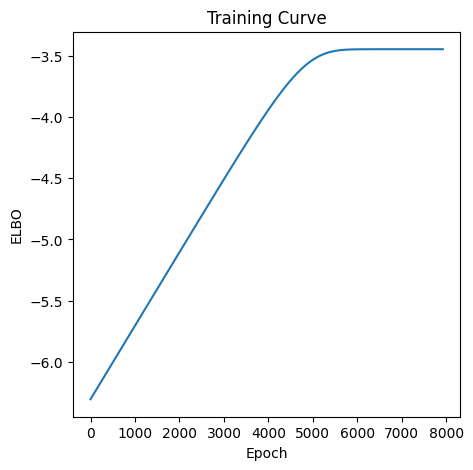

In [256]:
n = 1000
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/10]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
)

meanfield_gamma_restricted_on_standard_form = MeanFieldGammaRestrictedOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001
)

meanfield_gamma_restricted_on_standard_form.run_parameter_optimisation(8000)
fig = meanfield_gamma_restricted_on_standard_form.plot_training_curve();

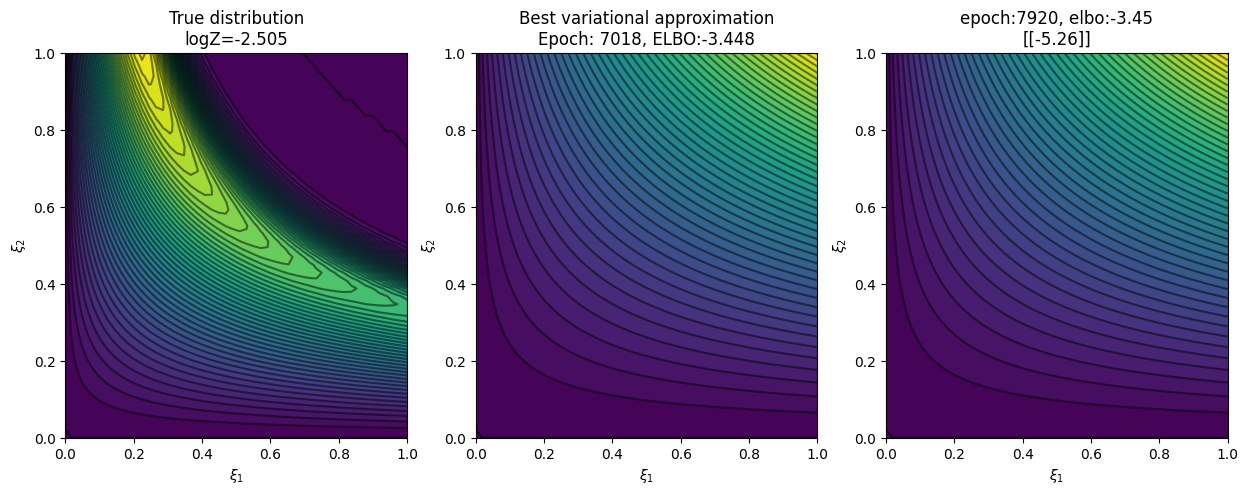

In [257]:
fig, video = meanfield_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

In [412]:
class MeanFieldTruncatedGammaRestrictedOn2DStandardForm(MeanFieldGammaRestrictedOn2DStandardForm):
    def __init__(self, n, k_0, lambda_0, lr=0.001):
        super(MeanFieldTruncatedGammaRestrictedOn2DStandardForm, self).__init__(
            n, k_0, lambda_0, lr=0.001
        )
        
    def elbo_fn(self):
        lambdas = self.lambdas
        ks = self.ks
        betas = torch.stack([self.beta1, torch.exp(self.logbetas)], dim=0)
        
        r = self.k_0 / ks
        
        term1 = self.n * torch.exp(torch.sum(
            -r * torch.log(betas) 
            +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
            + torch.log(torch.igamma(lambdas + r, betas)) - torch.log(torch.igamma(lambdas, betas))
        ))
        
        term2 = torch.sum(
            torch.log(2 * ks) + lambdas * torch.log(betas) 
            - torch.lgamma(lambdas) - torch.log(torch.igamma(lambdas, betas))
            - lambdas * (torch.igamma(lambdas + 1, betas) / torch.igamma(lambdas, betas))
#             + (lambdas - r * self.lambda_0) * (torch.digamma(lambdas) - torch.log(betas))
        )
        return -term1 - term2
    
    def variational_density(self, w, parameters):
        lambdas = self.lambdas
        ks = self.ks
        betas = torch.stack([self.beta1, torch.exp(parameters[0])], dim=0)

        betas = torch.exp(parameters[0])
        z = w ** (2 * ks * lambdas - 1) * torch.exp(-betas * (w**ks))
        normalising_const = (
            scipy.special.gamma(lambdas) * torch.igamma(lambdas, betas) 
            / (2 * ks * (betas ** (lambdas)))
        )
        z = torch.prod(z / normalising_const, axis=-1)
        return z

n        = 100000
lambda_0 = tensor([0.3000, 0.3000])
ks_0     = tensor([3, 4])
logZ     = -3.520

Epoch     0: elbo=-9.51, betas  =[array([100000.]), array([1.])]
Epoch   800: elbo=-9.47, betas  =[array([100000.]), array([0.54])]
Epoch  1600: elbo=-9.46, betas  =[array([100000.]), array([0.36])]
Epoch  2400: elbo=-9.46, betas  =[array([100000.]), array([0.26])]
Epoch  3200: elbo=-9.45, betas  =[array([100000.]), array([0.2])]
Epoch  4000: elbo=-9.45, betas  =[array([100000.]), array([0.16])]
Epoch  4800: elbo=-9.45, betas  =[array([100000.]), array([0.13])]
Epoch  5600: elbo=-9.45, betas  =[array([100000.]), array([0.1])]
Epoch  6400: elbo=-9.45, betas  =[array([100000.]), array([0.08])]
Epoch  7200: elbo=-9.45, betas  =[array([100000.]), array([0.07])]


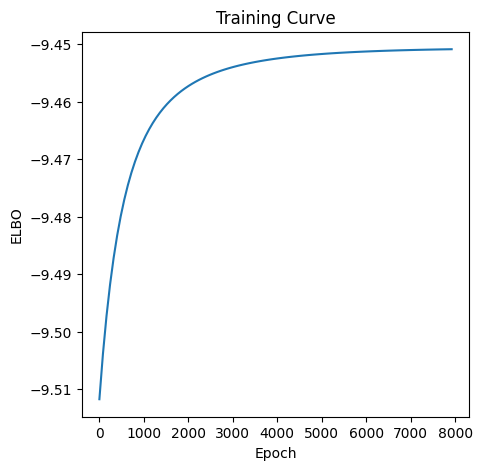

In [413]:
n = 100000
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/10]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1

meanfield_truncated_gamma_restricted_on_standard_form = MeanFieldTruncatedGammaRestrictedOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_restricted_on_standard_form.run_parameter_optimisation(8000)
fig = meanfield_truncated_gamma_restricted_on_standard_form.plot_training_curve();

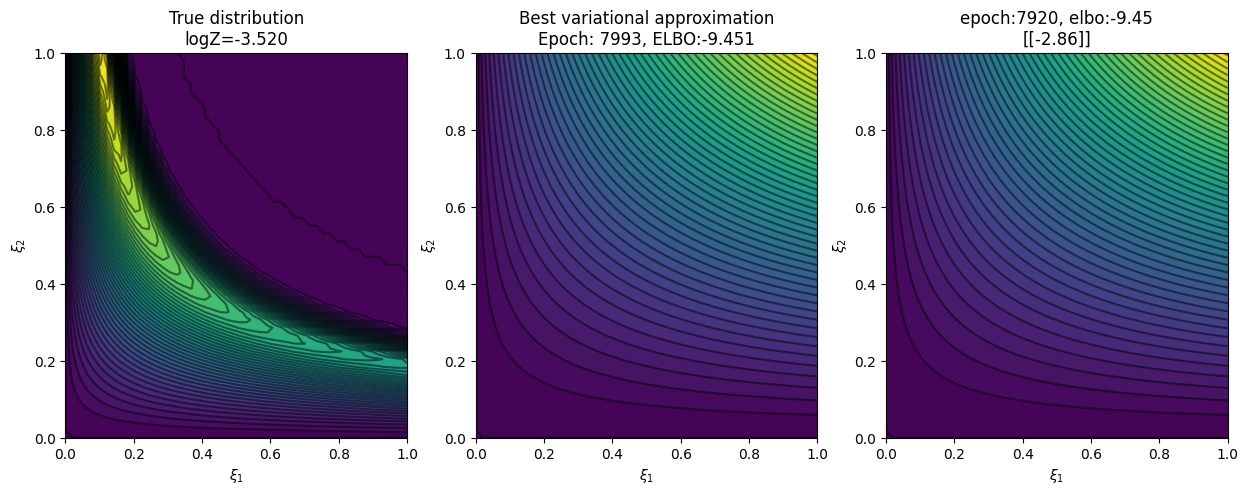

In [268]:
fig, video = meanfield_truncated_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Experiment 3.2:

In [411]:
igamma = RegularisedLowerIncompleteGamma.apply
gradigamma = GradLambdaRegularisedLowerIncompleteGamma.apply

class MeanFieldTruncatedGammaOn2DStandardForm(MeanFieldGammaOn2DStandardForm):
    def __init__(self, n, k_0, lambda_0, lr=0.001):
        super(MeanFieldTruncatedGammaOn2DStandardForm, self).__init__(
            n, k_0, lambda_0, lr=0.001
        )
         
    def elbo_fn(self):
        lambdas, ks, betas = [torch.exp(param) for param in self.parameters]
        logbetas = torch.log(betas)
        iglambdas_betas = igamma(lambdas, betas)
        r = self.k_0 / ks
        
        term1 = self.n * torch.exp(torch.sum(
            -r * logbetas
            +  torch.log(igamma(lambdas + r, betas)) - torch.log(iglambdas_betas)
        ))
        
        term2 = torch.sum(
            torch.log(2 * ks) + lambdas * torch.log(betas) 
            - torch.lgamma(lambdas) - torch.log(iglambdas_betas)
            - lambdas * (igamma(lambdas + 1, betas) / iglambdas_betas)
#             + (lambdas - r * self.lambda_0) * (gradigamma(lambdas, betas) / iglambdas_betas - torch.log(betas))
        )
        return -term1 - term2
    
    def variational_density(self, w, parameters):
        lambdas, ks, betas = [torch.exp(param).detach().numpy() for param in parameters]
        w = w.numpy()
        z = w ** (2 * ks * lambdas - 1) * np.exp(-betas * (w**ks))
        normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
        z = np.prod(z / normalising_const, axis=-1)
        return z

In [398]:
n = 10
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/4]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1

meanfield_truncated_gamma_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.00005
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_on_standard_form.run_parameter_optimisation(5000)
fig = meanfield_truncated_gamma_on_standard_form.plot_training_curve();

n        = 10
lambda_0 = tensor([0.3000, 0.7500])
ks_0     = tensor([3, 4])
logZ     = -1.707

Epoch     0: elbo=-3.38
lambdas=[0.3, 0.75]
ks     =[3.0, 4.0]
betas  =[10.01, 1.0]

Epoch   500: elbo=-5.42
lambdas=[0.11, 0.46]
ks     =[9.07, 7.61]
betas  =[19.94, 1.71]

Epoch  1000: elbo=-11.97
lambdas=[0.36, 0.46]
ks     =[44.76, 7.63]
betas  =[30.36, 1.41]

Epoch  1500: elbo=-14.74
lambdas=[0.83, 0.47]
ks     =[79.51, 7.46]
betas  =[19.41, 1.39]

Epoch  2000: elbo=-14.45
lambdas=[0.83, 0.47]
ks     =[79.55, 7.55]
betas  =[11.2, 1.39]



KeyboardInterrupt: 

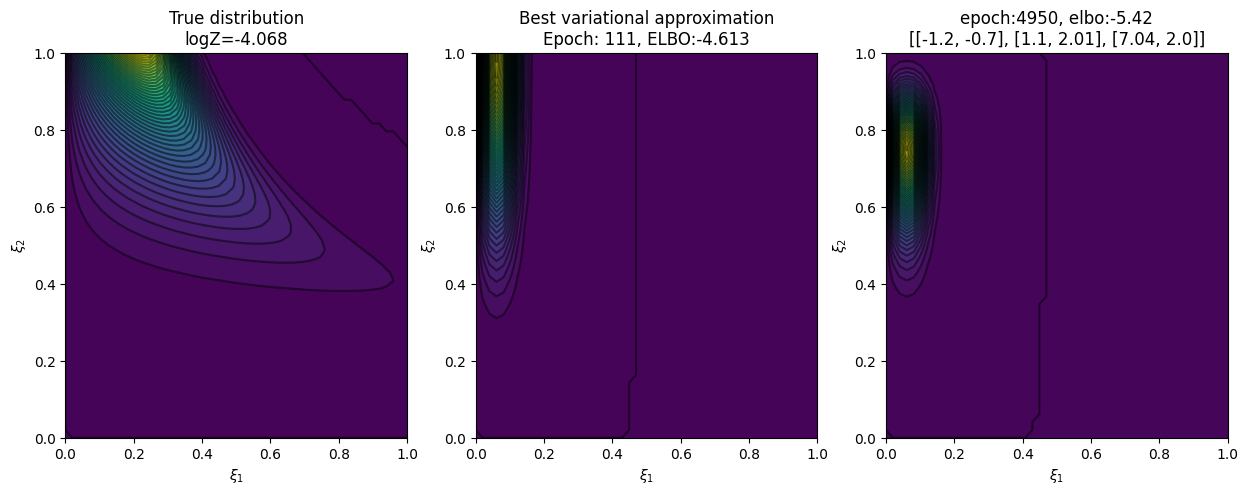

In [387]:
fig, video = meanfield_truncated_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# $n$-dependencies

In [ ]:
n = 10
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/4]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1
lr = 0.0005
num_epoch = 2000
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
#     f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)

dict(
    gaussian_on_standard_form = GaussianFamilyOn2DStandardForm(
        n=n,
        k_0=k_0,
        h_0=h_0,
        lr=lr
    )

    meanfield_gamma_restricted_on_standard_form = MeanFieldGammaRestrictedOn2DStandardForm(
        n=n,
        k_0=k_0,
        lambda_0=lambda_0, 
        lr=lr
    )

    meanfield_truncated_gamma_restricted_on_standard_form = MeanFieldTruncatedGammaRestrictedOn2DStandardForm(
        n=n,
        k_0=k_0,
        lambda_0=lambda_0, 
        lr=lr
    )
)


In [434]:
n = 10
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/4]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1
lr = 0.001
num_epoch = 1000
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
#     f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)

rec = []
for logn in range(1, 10):
    n = int(10**logn)
    vis = dict(
        mf_gamma=MeanFieldGammaRestrictedOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0,
            lr=lr
        ), 
        mf_gamma_trunc=MeanFieldTruncatedGammaRestrictedOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=lr
        ), 
#         gaussian=GaussianFamilyOn2DStandardForm(
#             n=n,
#             k_0=k_0,
#             h_0=h_0,
#             lr=lr
#         )
    )
    for vi_name, vi in vis.items():
        logZ = vi.log_evidence()
        vi.run_parameter_optimisation(num_epoch, verbose=False)
        elbo = vi.elbo_fn()
        print(f"{vi_name:20s}, n={n:15d}, logZ={logZ:.4f}, ELBO={elbo:.4f}")
        
        rec.append([vi_name, n, logZ, elbo.item()])

n        = 10
lambda_0 = tensor([0.3000, 0.7500])
ks_0     = tensor([3, 4])

mf_gamma            , n=             10, logZ=-2.8247, ELBO=-4.4604
mf_gamma_trunc      , n=             10, logZ=-2.8247, ELBO=-6.3397
mf_gamma            , n=            100, logZ=-3.4114, ELBO=-6.8346
mf_gamma_trunc      , n=            100, logZ=-3.4114, ELBO=-8.7556
mf_gamma            , n=           1000, logZ=-4.0677, ELBO=-9.2479
mf_gamma_trunc      , n=           1000, logZ=-4.0677, ELBO=-11.1731
mf_gamma            , n=          10000, logZ=-4.7465, ELBO=-11.6651
mf_gamma_trunc      , n=          10000, logZ=-4.7465, ELBO=-13.5908
mf_gamma            , n=         100000, logZ=-5.4331, ELBO=-14.0828
mf_gamma_trunc      , n=         100000, logZ=-5.4331, ELBO=-16.0085
mf_gamma            , n=        1000000, logZ=-6.1224, ELBO=-16.5005
mf_gamma_trunc      , n=        1000000, logZ=-6.1224, ELBO=-18.4263
mf_gamma            , n=       10000000, logZ=-6.8126, ELBO=-18.9183
mf_gamma_trunc      , n=       

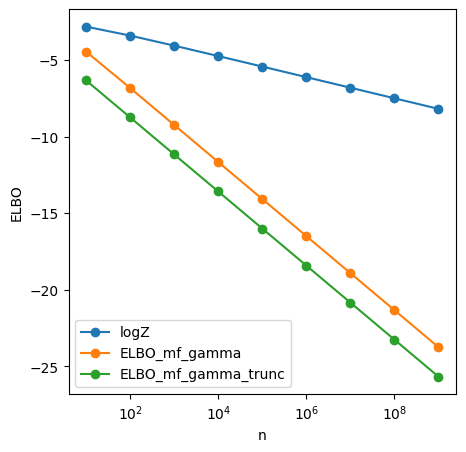

In [442]:
df = pd.DataFrame(rec, index=None)
df.columns = ["name", "n", "logZ", "ELBO"]
df = df.set_index("name")
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(df.loc["mf_gamma", "n"], df.loc["mf_gamma", "logZ"], "o-", label="logZ")

for name in df.index.unique():
    d = df.loc[name, :]
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO"], "o-", label=f"ELBO_{name}")
ax.set_xscale('log')
ax.set_xlabel("n")
ax.set_ylabel("ELBO")
ax.legend()

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family

# Misc

In [199]:
f = lambda y, x: gaussian_on_standard_form.true_unnormalised_density(torch.tensor([x, y]))
scipy.integrate.dblquad(f, 0, 1, 0, 1)

(0.02071806820989682, 1.4598133990106277e-08)

In [328]:

class CustomsFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x**2 + 13 * y
    
    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * 2 * x, grad_output * 13


In [343]:
f = CustomsFunc.apply
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(4., requires_grad=True)
z = f(x, y)
z.backward()

x.grad, y.grad

(tensor(6.), tensor(13.))

In [353]:
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(10., requires_grad=True)
z = igamma(x, y)
z.backward()
x.grad, y.grad

(tensor(0.0018), tensor(0.0045))